Importing the necessaries

In [20]:
from datasets import load_dataset
import numpy as np
import seaborn as sns

Loading the dataset from disk

In [3]:
train_dataset = load_dataset('rootblind/opjustice-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice-dataset', split='test')

Inspecting data

In [4]:
train_dataset.to_pandas().head()

,Message,OK,Insult,Violence,Sexual,Hateful,Flirt,Spam,Aggro
0,ii rupem pe bot,1,0,0,0,0,0,0,0
1,excelent jungler ( 🥵 evelynn & rengar 😳 ) 20/...,1,0,0,0,0,0,0,0
2,"Veigar ฅ^•ﻌ•^ฅ 🌺 , Andu astro feeders :p",1,0,0,0,0,0,0,0
3,inting,1,0,0,0,0,0,0,0
4,minte ca nu e smurf si trolleaza de pe contu mic,1,0,0,0,0,0,0,0


In [5]:
test_dataset.to_pandas().head()

,Message,OK,Insult,Violence,Sexual,Hateful,Flirt,Spam,Aggro
0,handicapat,0,1,0,0,0,0,0,0
1,retardat,0,1,0,0,0,0,0,0
2,cretin,0,1,0,0,0,0,0,0
3,terminatule,0,1,0,0,0,0,0,1
4,te bat,0,0,1,0,0,0,0,1


Converting the dataset to pandas for easier analysis

In [6]:
import pandas as pd

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

df_train.describe()

,OK,Insult,Violence,Sexual,Hateful,Flirt,Spam,Aggro
count,6904.000000,6904.000000,6904.000000,6904.000000,6904.000000,6904.000000,6904.000000,6904.000000
mean,0.886008,0.031431,0.007387,0.040122,0.011298,0.006373,0.001014,0.054461
std,0.317824,0.174492,0.085636,0.196259,0.105697,0.079583,0.031828,0.248863
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


In [7]:
df_test.describe()

,OK,Insult,Violence,Sexual,Hateful,Flirt,Spam,Aggro
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,0.644578,0.121988,0.117470,0.106928,0.082831,0.018072,0.016566,0.194277
std,0.479002,0.327519,0.322222,0.309254,0.275835,0.133313,0.127736,0.395941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6904 entries, 0 to 6903
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   6904 non-null   object
 1   OK        6904 non-null   int64 
 2   Insult    6904 non-null   int64 
 3   Violence  6904 non-null   int64 
 4   Sexual    6904 non-null   int64 
 5   Hateful   6904 non-null   int64 
 6   Flirt     6904 non-null   int64 
 7   Spam      6904 non-null   int64 
 8   Aggro     6904 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 485.6+ KB


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   664 non-null    object
 1   OK        664 non-null    int64 
 2   Insult    664 non-null    int64 
 3   Violence  664 non-null    int64 
 4   Sexual    664 non-null    int64 
 5   Hateful   664 non-null    int64 
 6   Flirt     664 non-null    int64 
 7   Spam      664 non-null    int64 
 8   Aggro     664 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 46.8+ KB


In [9]:
df_train.isnull().sum()

Message     0
OK          0
Insult      0
Violence    0
Sexual      0
Hateful     0
Flirt       0
Spam        0
Aggro       0
dtype: int64

In [15]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (6904, 9)
Test shape:  (664, 9)


In [16]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 119
Number of duplicated instances in test: 27


In [19]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                OK    Insult  Violence    Sexual   Hateful     Flirt  \
OK        1.000000 -0.502222 -0.240506 -0.569985 -0.298020 -0.223278   
Insult   -0.502222  1.000000  0.013544  0.073155  0.232091 -0.003995   
Violence -0.240506  0.013544  1.000000  0.034079  0.038792  0.014347   
Sexual   -0.569985  0.073155  0.034079  1.000000  0.006079  0.011451   
Hateful  -0.298020  0.232091  0.038792  0.006079  1.000000  0.008661   
Flirt    -0.223278 -0.003995  0.014347  0.011451  0.008661  1.000000   
Spam     -0.088818  0.020345  0.050401  0.039869  0.082718  0.054640   
Aggro    -0.593671  0.230791  0.076284  0.245924  0.081244  0.004416   

              Spam     Aggro  
OK       -0.088818 -0.593671  
Insult    0.020345  0.230791  
Violence  0.050401  0.076284  
Sexual    0.039869  0.245924  
Hateful   0.082718  0.081244  
Flirt     0.054640  0.004416  
Spam      1.000000  0.029606  
Aggro     0.029606  1.000000  


Data visualization

In [10]:
import matplotlib.pyplot as plt # importing the neccessary library

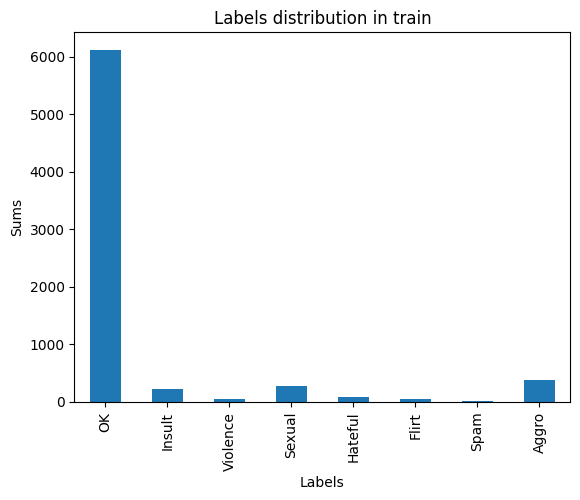

OK          6117
Insult       217
Violence      51
Sexual       277
Hateful       78
Flirt         44
Spam           7
Aggro        376
dtype: int64


In [11]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

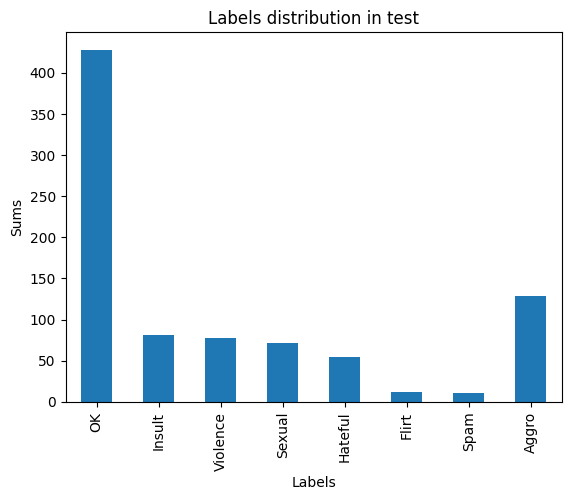

OK          428
Insult       81
Violence     78
Sexual       71
Hateful      55
Flirt        12
Spam         11
Aggro       129
dtype: int64


In [12]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

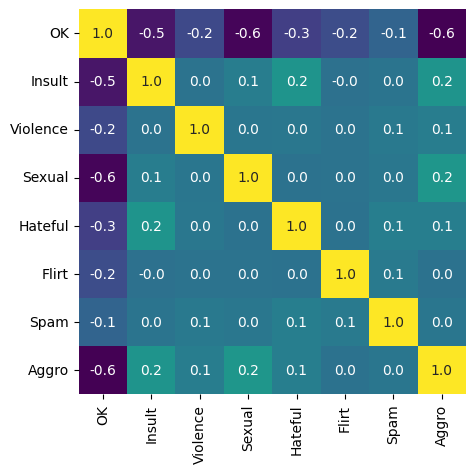

In [21]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

Comparing the train and the test datasets sizes

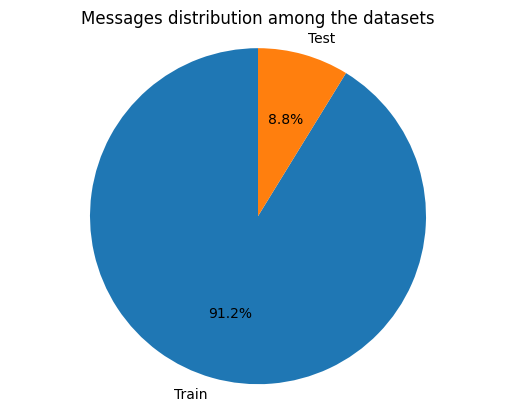

[6904, 664]


In [13]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)